<h2><center>THE CHINESE UNIVERSITY OF HONG KONG<br /> 
    Department of Mathematics<br />
 MATH4280<br />
    Innovation and Design in Big Data Analytics<br />
    Sample Test</center></h2>
    

## Question 2

In [1]:
from numpy import sqrt
from pandas import read_csv
from pydmd import DMD
import numpy as np
import matplotlib.pyplot as plt

path = 'housing_price.csv'
df = read_csv(path)
data=np.array(df).T

We look at the `housing` dataset. It contains variables related to the housing price. The last row of `data` is the time series of the housing price.


The data is structed like this:
$${\bf D}=\left[\begin{array}{cccc}{\bf x_0} & {\bf x_1} &\cdots & {\bf x_{505}}\\
p_0 & p_1 &\cdots& p_{505}\end{array}\right]$$

where $\bf x_t$ is a column vector of some related variables and $p_t$ is the housing price at time $t$.

Apply DMD to `data` and find `svd_rank` so that the relative error of reconstructed data is less than 0.4.

In [2]:
## answer 2a
errors=np.zeros(14)
for i,svd_rank in enumerate(range(1,15)):
    dmd=DMD(svd_rank=svd_rank,tlsq_rank=1)
    dmd.fit(data)
    errors[i]=np.linalg.norm(dmd.reconstructed_data.real-data)/np.linalg.norm(data)
print(f'The optimal svd_rank is {np.where(errors==min(errors))[0][0]+1} with relative error = {min(errors)}')

The optimal svd_rank is 2 with relative error = 0.36080852851937334


What is the relative error for the housing price time series (the last row of `data`) for that `svd_rank`?

In [3]:
## answer of 2b
dmd=DMD(svd_rank=14)
dmd.fit(data)
error=np.linalg.norm(dmd.reconstructed_data.real[-1,:]-data[-1,:])/np.linalg.norm(data[-1,:])
print(f'relative error for the housing price reconstruction: {error}')

relative error for the housing price reconstruction: 0.4763767661643138


If we only look at the first 10 days, say
$$D_{10} = \begin{bmatrix}\mathbf{x}_0 & \cdots &\mathbf{x}_{9}\\
p_0 & \cdots & p_{9}
\end{bmatrix}$$

Apply DMD with a suitable `svd_rank` (within 1 and 14).

Make the DMD delta time a quarter of the original and extend the temporal window to  $[0,2t_{org}]$, where $t_{org}$ indicates the time when the last snapshot was caught.

Plot the resultant figure along with the original data.

The desired svd_rank is 9. The relative error is 0.0005882040924467837.


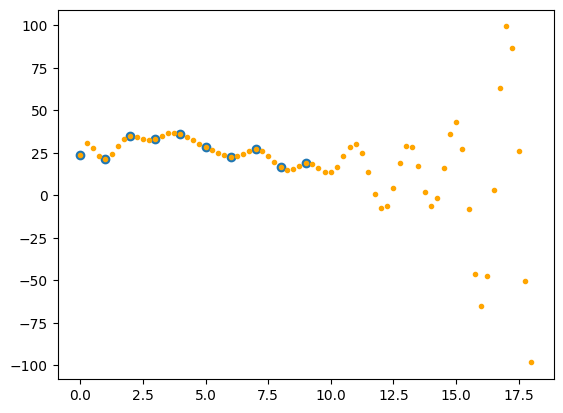

In [4]:
## answer 2c
errors=np.zeros(14)
for i,svd_rank in enumerate(range(1,15)):
    dmd=DMD(svd_rank=svd_rank,tlsq_rank=0)
    dmd.fit(data[:,:10])
    errors[i]=np.linalg.norm(dmd.reconstructed_data.real-data[:,:10])/np.linalg.norm(data[:,:10])
min_svd_rank = np.where(errors==min(errors))[0][0]+1
print(f'The desired svd_rank is {min_svd_rank}. The relative error is {min(errors)}.')
dmd=DMD(svd_rank=min_svd_rank,tlsq_rank=0)
dmd.fit(data[:,:10])
dmd.dmd_time['dt'] *= 0.25
dmd.dmd_time['tend'] *= 2
plt.scatter(dmd.original_timesteps, data[-1,:10])
plt.scatter(dmd.dmd_timesteps, dmd.reconstructed_data.real[-1,:],color='orange',marker='.')
plt.show()

Now, we want to only model the time series of `housing_price`, instead of the whole data matrix. 

Denote the time series by $(p_0,p_1,\cdots,p_T)$. We can form the Hankel matrix by

$$\begin{align*}
H = \left[\begin{array}{cccccc}
p_0 & p_1 & p_2 & \cdots & p_{T-k} & p_{T-k+1} \\
p_1 & p_2 & p_3 & \cdots & p_{T-k+1} & p_{T-k+2} \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
p_{k-1} & p_k & p_{k+1} & \cdots & p_{T-1} & p_{T}
\end{array}\right]
\end{align*}$$

Simply put, each column of $H$ records a window of $k$ consecutive values of the series. 

Now complete the function `hankel` to construct the Hankel matrix, given a one-dimensional array `ts` denoting the time series and the window size `k`.


In [5]:
housing_price=data[-1,:]
def hankel(ts,k):
    ## answer of 2d
    
    result=np.zeros((k,ts.shape[0]-k+1))
    for i in range(result.shape[1]):
        result[:,i]=ts[i:i+k]
        
        
    return result
tmp=housing_price.shape[0]
x=np.array([i for i in range(tmp)])
X=hankel(x,10)
X[:,-1]


array([496., 497., 498., 499., 500., 501., 502., 503., 504., 505.])

By applying DMD to $H$, we are approximating the matrix $\bf A$,
$$\begin{align*}
\left[\begin{array}{cccc}
p_1 & p_2 & \cdots & p_{T-k+1} \\
p_2 & p_3 & \cdots & p_{T-k+2} \\
\vdots & \vdots & \vdots & \vdots \\
p_{k} & p_{k+1} & \cdots & p_{T} \end{array}\right]
\approx {\bf A}
\left[\begin{array}{cccc}
p_0 & p_1 & \cdots & p_{T-k} \\
p_1 & p_2 & \cdots & p_{T-k+1} \\
\vdots & \vdots & \vdots & \vdots \\
p_{k-1} & p_{k} & \cdots & p_{T-1} \end{array}\right]
\end{align*}$$

Now if we fix `svd_rank=14` and `k`$=10,20,50,100$ or $200$, what is the optimal value for the window size `k` so that the relative reconstruction error is minimal?

In [6]:
## answer of 2e
errors=np.zeros(5)
ws=[10,20,50,100,200]
for i,k in enumerate(ws):
    dmd=DMD(svd_rank=14)
    H=hankel(housing_price,k)
    dmd.fit(H)
    errors[i]=np.linalg.norm(dmd.reconstructed_data.real-H)/np.linalg.norm(H)
print(f'The optimal window size is {ws[np.where(errors==min(errors))[0][0]]} with relative error = {min(errors)}')

The optimal window size is 200 with relative error = 0.2785109037086909


Using your choice of window size of (2e), apply DMD to estimate $p_{506}$.

In [7]:
## answer of 2f
dmd=DMD(svd_rank=14)
H=hankel(housing_price,200)
dmd.fit(H)
dmd.dmd_time['tend'] += dmd.dmd_time['dt']
print("The required value is "+ str(dmd.reconstructed_data[-1,-1].real))

The required value is 18.545969668353848
